# Get P. Terry's Burger Stand locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
import urllib.request
import usaddress

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### All the links from the locations page

In [8]:
link_response = requests.get("https://pterrys.com/locations")
link_html = BeautifulSoup(link_response.text, "html.parser")
links = link_html.select("a[href*=locations]")

In [ ]:
links_list = []

for l in links:
    links_list.append("https://www.aubonpain.com" + l["href"])

#### Get details from each page

In [6]:
pages_list = []

for l in tqdm(links_list):
    try:
        page_response = requests.get(l)
        page_response.raise_for_status()  # Raise an exception for bad responses
        page_html = BeautifulSoup(page_response.text, "html.parser")

        # Find the script tag containing the "loadMapScenario" function
        page_details = page_html.find(
            "script", string=lambda s: s and "loadMapScenario" in s
        )

        if page_details:
            # Extract the script content
            script_content = page_details.string

            # Extract the "location" variable from the script
            location_start = script_content.find("location:") + len("location:")
            location_end = script_content.find(")", location_start) + 1
            location_variable = script_content[location_start:location_end].strip()

            page_dict = {
                "name": page_html.find("h3").text,
                "address": page_html.findAll("dd")[0].text,
                "city_state_zip": page_html.findAll("dd")[1].text,
                "phone": page_html.findAll("dd")[2].text,
                "coordinates": location_variable.replace(")", "").replace(
                    "new Microsoft.Maps.Location(", ""
                ),
            }

            pages_list.append(page_dict)
        else:
            print(f"Script not found on the page. {location_name}")

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
    except Exception as ex:
        print(f"An unexpected error occurred: {ex}")

  0%|          | 0/72 [00:00<?, ?it/s]

An unexpected error occurred: name 'location_name' is not defined


#### Read list of dictionaries into a dataframe

In [7]:
src = pd.DataFrame(pages_list)

#### How many locations did we capture? 

In [8]:
len(src)

71

#### Clean up location names and addresses

In [9]:
src[["name", "type", "drop"]] = src["name"].str.split("(", expand=True)
src["address"] = src["address"].str.replace(",", "", regex=False)
src["state"] = src["city_state_zip"].str.split(",", expand=True)[1].str[:3]
src["city"] = src["city_state_zip"].str.split(",", expand=True)[0]
src["zip"] = src["city_state_zip"].str.split(",", expand=True)[1].str[3:]
src["type"] = src["type"].str.replace(")", "", regex=False)
src[["lat", "lon"]] = src["coordinates"].str.split(",", expand=True)

#### Clean dataframe

In [10]:
df = src.drop(["drop", "city_state_zip", "coordinates"], axis=1).copy()

#### The result: 

In [11]:
df.head()

,name,address,phone,type,state,city,zip,lat,lon
0,Quinnipiac University,275 Mt. Carmel Avenue,203-582-8250,Franchise,CT,Hamden,06518,41.4198,-72.8947
1,Quinnipiac University Kiosk,275 Mt. Carmel Avenue,203-500-9079,"Franchise, Temporarily Closed",CT,Hamden,06518,41.4191748,-72.8926883
2,The Hospital of Central Connecticut,100 Grand Ave.,860-224-5165,Franchise,CT,New Britain,06052,41.6613,-72.7876
3,Christiana Hospital,4755 Ogletown Stanton Road,302-733-1188,None,DE,Newark,19718,39.6875,-75.6692
4,Wilmington Hospital,501 W. 14th St. Second Fl.,302-320-5888,None,DE,Wilmington,19801,39.7507,-75.5502


----

## Geography

#### Make a geodataframe from lon/lat

In [12]:
df_geo = df.copy()

In [13]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.lon, df_geo.lat)
).set_crs("epsg:4326")

<AxesSubplot: >

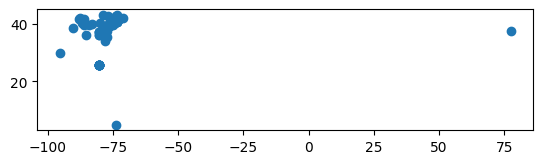

In [14]:
gdf.plot()

---

## Exports

#### CSV

In [15]:
df.to_csv("data/processed/au_bon_pain_locations.csv", index=False)

#### JSON

In [16]:
df.to_json("data/processed/au_bon_pain_locations.json", indent=4, orient="records")

#### GeoJSON

In [17]:
gdf.to_file("data/processed/au_bon_pain_locations.geojson", driver="GeoJSON")